In [4]:
%pylab inline
from PIL import Image
import geopandas as gpd

Populating the interactive namespace from numpy and matplotlib


In [5]:
rad_im_f = "./images/radargram.png"
rad_gpkg_f = "./images/radargram.gpkg"

import fiona # we use fiona directly just to list the available layer
fiona.listlayers(rad_gpkg_f) # list the available layers

['depth_grid', 'stations', 'horizons', 'time']

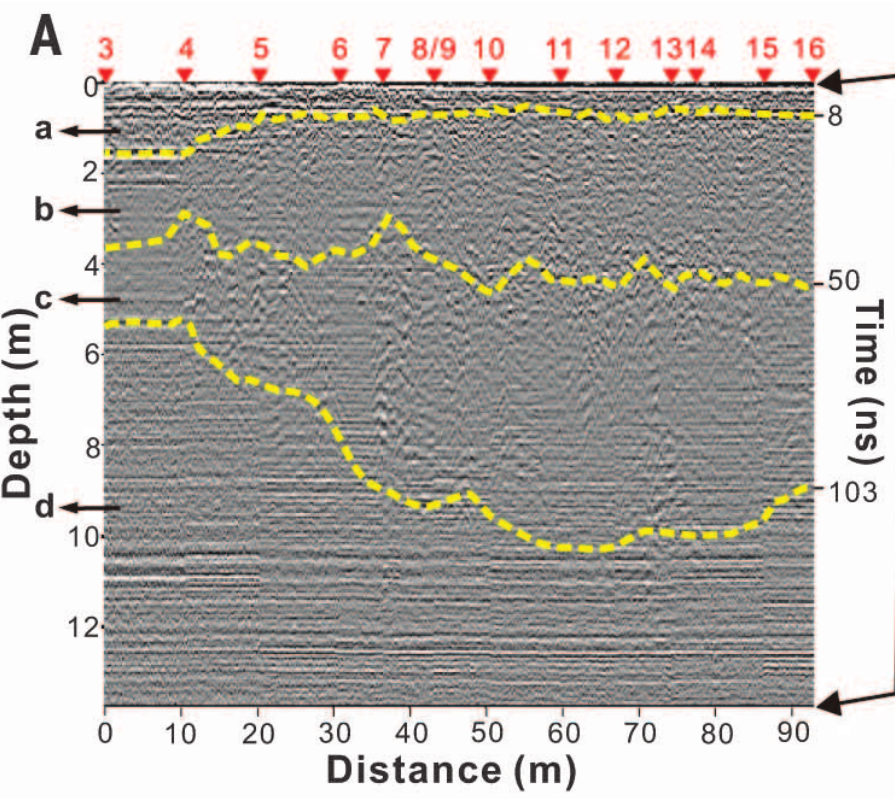

In [6]:
rad = Image.open(rad_im_f)
rad

We determine the scale and translation of the plt using the depth_grid data in the geopackage

In [7]:
depths = gpd.read_file(rad_gpkg_f, layer='depth_grid')
depths.crs = None # force to none, irrelevant if was set

to estimate the reference frame (the transform from pixels to meters, we use a different approach here)
We create the system to be solved directly. This approach is not perfect but still ok for our purposes


In [8]:
# create the matrix and the b vector of the system Ax=b, we will find x
A = []
b = []
for id, (xm, ym, pt) in depths.iterrows():
    xp, yp = np.array(pt.coords)[0]
    A.append([xp,0,1,0])    
    b.append(xm)
    A.append([0,yp,0,1])
    b.append(ym)
    
A = np.array(A)        
b = np.array(b)

In [9]:
not_nans = ~np.isnan(b) # we remove the nans, where a measure was not available, in x or y dimension (meters)
A = A[not_nans]
b = b[not_nans]

In [10]:
x, sqnorm, rank, s  = numpy.linalg.lstsq(A, b) # solution
a,b,x_0, y_0 = x

<ipython-input-10-71201d039a57>:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x, sqnorm, rank, s  = numpy.linalg.lstsq(A, b) # solution


In [11]:
ratio = a/b
print(f"ratio of scales {ratio}") # the original plot has vertical exagerration of 6x

ratio of scales 5.93099659698647


In [12]:
# we use homogeneus coordinats and set up the transform, scale and translation are considered
# we assembly the matrix 
T = np.array([[a, 0, x_0], 
              [0, b, y_0],
              [0, 0,  1 ]])

np.savetxt("radargram_transform.txt", T) # and save for future uses

In [13]:
# extract and prepare the points to be transformed
pt_px = np.array([np.array(p.coords)[0] for p in depths.geometry])
pt_px = np.column_stack([pt_px, np.ones(len(pt_px))])



In [14]:
# apply the transform on te input points just to check how far we are
pt_mt_est = np.array([T@pt for pt in pt_px])[:,:2]
pt_mt_obs = np.column_stack([depths.x, depths.y])
pt_mt_obs - pt_mt_est 

array([[ 0.09057928, -0.0034278 ],
       [-0.00874756,  0.01180361],
       [ 0.04801064, -0.00566165],
       [ 0.05747034, -0.00079748],
       [ 0.02436139, -0.01028794],
       [ 0.05747034,  0.0073359 ],
       [ 0.09530913,  0.00103536],
       [-0.11280426,         nan],
       [-0.14008599,         nan],
       [-0.16736772,         nan],
       [-0.02437485,         nan],
       [ 0.00510162,         nan],
       [ 0.01565869,         nan],
       [ 0.02621577,         nan],
       [-0.00579581,         nan],
       [ 0.00949111,         nan],
       [ 0.02950788,         nan]])

just to see if we are near enough, around 0.1 meters is the error in progressive positioning due to digitalization

lower than 0.01 m is the error in depth positioning for the depth positioning due to digitalization

note this is not measurement error! it is just related to our ability to pass from px to m coordinates, given the two axis of the original image have different scales, we are better in determining depth rather than positioning

# Now we read the stations
and we estimate the progressive positioning of them in meters

In [15]:
stations = gpd.read_file(rad_gpkg_f, layer='stations')

In [16]:
stations_x_px = np.array([np.array(p.coords)[0][0] for p in stations.geometry])
stations_x_px # the progressive positioning in px

array([105.8093507 , 184.17594377, 259.21789349, 339.76925219,
       382.51466659, 434.56908235, 490.80304974, 561.2854886 ,
       616.5695579 , 671.66364757, 696.74095735, 764.56368154,
       813.95838263])

In [17]:
stations_x_m = a*stations_x_px+x_0 # trasnsform the values in px to m
stations_x_m # progressive positions in meters of the corresponding station point
stations["progressive_m"] = stations_x_m # add it to the dataframe

In [18]:
stations

,sid,geometry,progressive_m
0,3,POINT (105.809 -80.628),0.241860
1,4,POINT (184.176 -81.150),10.490636
2,5,POINT (259.218 -81.340),20.304615
3,6,POINT (339.769 -81.530),30.839114
4,7,POINT (382.515 -81.720),36.429356
5,8/9,POINT (434.569 -81.530),43.237028
6,10,POINT (490.803 -81.530),50.591301
7,11,POINT (561.285 -81.910),59.808988
8,12,POINT (616.570 -81.530),67.039033
9,13,POINT (671.664 -82.100),74.244233


# The horizons now
similarly as above, we estimate the positions in meters for each node of the polylines defining the horizons

In [19]:
horizons = gpd.read_file(rad_gpkg_f, layer='horizons') # read the horizons as 3 linestrings
horizons # we have just 3 linestrins we need to transform

,hid,geometry
0,0,"LINESTRING (103.200 -152.298, 147.179 -153.744..."
1,1,"LINESTRING (103.490 -246.909, 116.799 -247.199..."
2,2,"LINESTRING (102.911 -325.029, 116.799 -322.714..."


In [20]:
# apply th transform to the linestrings, this is a nice way of doing that:
gtr = horizons.geometry.affine_transform([a, 0, 0, b,x_0, y_0])

horizons_m = horizons.copy() # duplicate the dataframe for the meters versio
horizons_m["geometry"] = gtr



# We now have everything to reproduce the plot 

We reproduce the plot, to check that the digitalizaion went fine

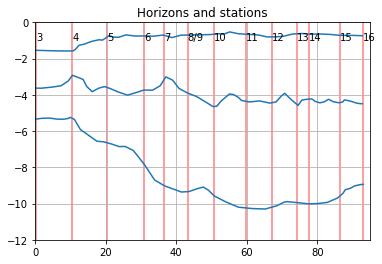

In [21]:
figure()
title("Horizons and stations")
horizons_m.plot(ax=gca())
axis("auto")
ylim(-12, 0)
xlim(0, 95)
grid(1)

vlines(stations.progressive_m, -12, 0, zorder=-10, alpha=0.5, color="red")

for i, (sid, m) in stations[["sid", "progressive_m"]].iterrows():
    text( m, -1, str(sid))

In [22]:
# we reconstruct the per pixel positioning of the image, we could also use imshow() with extend argument
xx = np.arange(rad.size[0])+0.5 
yy = -(np.arange(rad.size[1])+0.5)
X, Y= np.meshgrid(xx,yy)

In [23]:
px = np.column_stack([X.ravel(), Y.ravel()])
px = np.column_stack([px, np.ones(len(px))]) # add the ones as last column, we use an augmented matrix for the affine transform

In [24]:
tr = px.dot(T.T) # apply the transform
XX = tr[:,0].reshape(X.shape)
YY = tr[:,1].reshape(Y.shape)

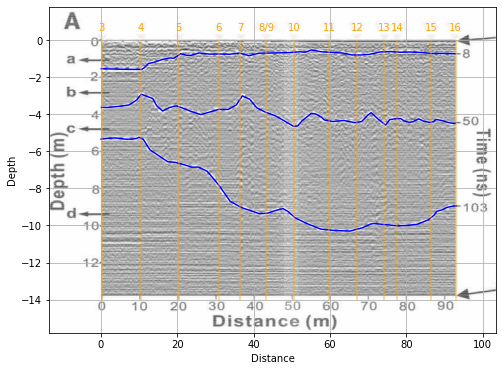

In [48]:
# now we can plot the original radargram together with the digitized traces
figure(figsize=(8,6))
pcolormesh(XX,YY,np.array(rad)[:,:,0], cmap="gray", alpha=0.1)
horizons_m.plot(ax=gca(), color="blue")
grid()
axis("auto");
vlines(stations.progressive_m, -14, 0, zorder=10, alpha=0.5, color="orange")

for i, (sid, m) in stations[["sid", "progressive_m"]].iterrows():
    text( m, 0.5, str(sid), color="orange",horizontalalignment='center')
    
xlabel("Distance")
ylabel("Depth")
savefig("recreated.png", dpi=300)

In [33]:
text?

Signature: text(x, y, s, fontdict=None, withdash=<deprecated parameter>, **kwargs)
Docstring:
Add text to the axes.

Add the text *s* to the axes at location *x*, *y* in data coordinates.

Parameters
----------
x, y : scalars
    The position to place the text. By default, this is in data
    coordinates. The coordinate system can be changed using the
    *transform* parameter.

s : str
    The text.

fontdict : dictionary, optional, default: None
    A dictionary to override the default text properties. If fontdict
    is None, the defaults are determined by your rc parameters.

withdash : boolean, optional, default: False
    Creates a `~matplotlib.text.TextWithDash` instance instead of a
    `~matplotlib.text.Text` instance.

Returns
-------
text : `.Text`
    The created `.Text` instance.

Other Parameters
----------------
**kwargs : `~matplotlib.text.Text` properties.
    Other miscellaneous text parameters.

Examples
--------
Individual keyword arguments can be used to override a

In [26]:
horizons_m.to_pickle("horizons.pickle") #  we save them as pickle
stations.to_pickle("stations.pickle")